# Importance Sampling by Reparameterization

## Imports

In [1]:
from typing import Literal, TypeVar, Union
import imageio.v3 as iio
import tqdm
import matplotlib.pyplot as plt
import numpy as np

import drjit as dr
import drjit.nn as nn
from drjit.opt import Adam, GradScaler
from drjit.auto.ad import (
    Texture2f,
    TensorXf,
    TensorXf16,
    Float16,
    Float32,
    ArrayXf,
    ArrayXf16,
    Array2f,
    Array3f,
)

In [18]:


def square_to_std_normal(sample: Array2f):
    """
    Transform uniform samples to standard normal using Box-Muller transform.

    Args:
        sample: 2D uniform samples from [0,1)²

    Returns:
        2D samples from standard normal distribution N(0,1)
    """
    r = dr.sqrt(-2.0 * dr.log(1.0 - sample[0]))
    phi = 2.0 * dr.pi * sample[1]

    s, c = dr.sincos(phi)
    return Array2f(c * r, s * r)


def std_normal_pdf(z: dr.ArrayBase):
    """
    Evaluate log probability density of standard normal distribution.

    For a d-dimensional standard normal: log p(z) = -d/2 * log(2π) - 1/2 * ||z||²
    """
    return 1.0 / dr.sqrt(dr.two_pi) * dr.exp(-dr.square(z) * 0.5)


ArrayT = TypeVar("ArrayT", bound=dr.ArrayBase)
Shape = Union[int, tuple[int, ...]]


def randn(self, dtype: type[ArrayT], shape: Shape) -> ArrayT:
    assert len(shape) == 2

    # Round up to next multiple of 2
    n = shape[0] if shape[0] % 2 == 0 else shape[0] + 1
    shape_gen = (n, shape[1])

    sample = self.random(dtype, shape_gen)
    result = []
    for i in range(0, len(sample), 2):
        x, y = square_to_std_normal(dtype(sample[i], sample[i + 1]))
        result.append(x)
        result.append(y)
    return dtype(result[: shape[0]])


# Monkeypatch randn
dr.random.Generator.randn = randn

rng = dr.rng(seed=0)

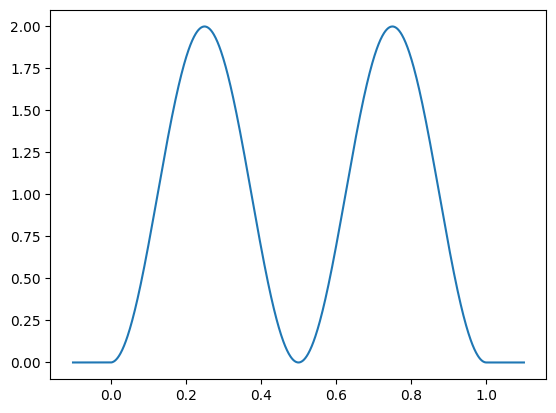

In [3]:
class Distr:
    def pdf(self, x: Float32) -> Float32: ...


class SinDistr:
    """
    A simple bimodal distribution, constructed using a sin function.
    """

    def pdf(self, x: Float32) -> Float32:
        active = (x >= 0) & (x <= 1)
        p = dr.square(dr.sin(x * dr.two_pi))
        return dr.select(active, p, 0) * 2


ref = SinDistr()

x_ref = dr.linspace(Float32, -0.1, 1.1, 1_000)
w_ref = ref.pdf(x_ref)

plt.plot(x_ref, w_ref)

## Second order Gradients

The paper requires us to compute the determinant of the jacobian in a
differentiable manner. In PyTorch, this can be handled with second order
gradients. However, Dr.Jit does not support them. We therefore implement a
custom network, which allows us to compute the gradients w.r.t. the inputs
differentiably.

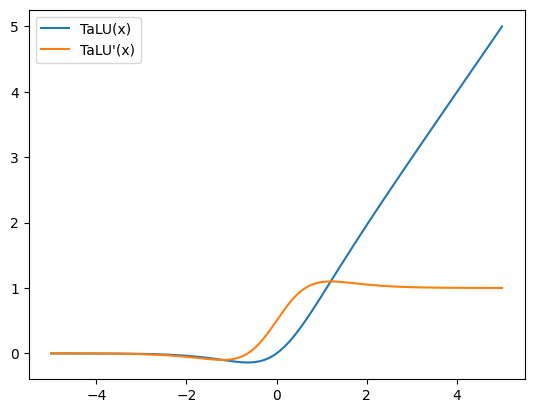

In [4]:


class TaLU(nn.Module):

    DRJIT_STRUCT = {}

    def __call__(self, x: nn.CoopVec | dr.ArrayBase, /) -> nn.CoopVec:
        return x * (dr.tanh(x) + 1) * 0.5

    def grad_(self, x: nn.CoopVec, dy: nn.CoopVec) -> nn.CoopVec:
        y = dr.tanh(x)
        J = 0.5 * (y - x * y * y + x + 1)
        return dy * J


act = TaLU()
x = dr.linspace(Float32, -5, 5, 1_000)
y = act(x)
dx = act.grad_(x, 1)
plt.plot(x, y, label="TaLU(x)")
plt.plot(x, dx, label="TaLU'(x)")
plt.legend()

In [5]:


class Resize(nn.Module):

    DRJIT_STRUCT = {
        "config": tuple,
    }

    def __init__(
        self,
        n_inputs: int | None = None,
        n_outputs: int | None = None,
    ) -> None:
        self.config = (n_inputs, n_outputs)

    def __call__(self, x: nn.CoopVec | dr.ArrayBase, /) -> nn.CoopVec:
        n_inputs, n_outputs = self.config
        tp = x.type

        x = list(x)
        y = []
        for i in range(n_outputs):
            if i < n_inputs:
                y.append(x[i])
            else:
                y.append(tp(0))

        return nn.CoopVec(y)

    def grad_(self, x: nn.CoopVec, dy: nn.CoopVec) -> nn.CoopVec:
        n_inputs, n_outputs = self.config
        tp = x.type
        assert len(x) == n_inputs
        assert len(dy) == n_outputs

        dy = list(dy)
        dx = []
        for i in range(n_inputs):
            if i < n_outputs:
                dx.append(dy[i])
            else:
                dx.append(tp(0))

        return nn.CoopVec(dx)

In [6]:


class JacobianNet(nn.Module):
    DRJIT_STRUCT = {
        "module": nn.Sequential,
    }

    inputs: list[nn.CoopVec] = []
    output: nn.CoopVec | None = None
    i: int = 0

    def __init__(self, module: nn.Module | None = None) -> None:
        self.module = module

    def _alloc(
        self, dtype: type[dr.ArrayBase], size: int, rng: dr.random.Generator, /
    ) -> tuple[nn.Module, int]:

        module, size = self.module._alloc(dtype, size, rng)

        result = JacobianNet(module)
        return result, size

    def clear(self):
        """
        Clears the stored input values for each layer.

        This method resets the internal state by emptying the inputs list,
        which contains the input values passed to each layer during the
        forward pass. This is necessary before each new forward evaluation
        to ensure that gradient computations use the correct layer inputs
        and don't accumulate stale data from previous evaluations.
        """
        self.inputs = []

    def __call__(self, x: nn.CoopVec) -> nn.CoopVec:
        """
        Evaluates the network while storing the inputs to each layer.

        This method performs a forward pass through the neural network while
        capturing and storing the input values that are passed to each layer.
        These stored inputs are essential for computing gradients later using
        the custom gradient computation in the grad() method.

        The stored inputs enable manual gradient computation since Dr.Jit doesn't
        support second-order gradients, which are required for computing the
        determinant of the Jacobian in a differentiable manner.

        Args:
            x: Input CoopVec to evaluate the network with

        Returns:
            CoopVec: Output of the network after forward evaluation
        """
        self.clear()
        if isinstance(self.module, nn.Sequential):
            for layer in self.module:
                self.inputs.append(x)
                x = layer(x)
        else:
            self.inputs.append(x)
            x = layer(x)
        self.output = x
        return x

    def grad_(self, module: nn.Module, dy: nn.CoopVec) -> nn.CoopVec:
        """
        Computes the gradient of the module after evaluating it.

        Args:
            module: The neural network module to compute gradients for
            x: Input CoopVec that was passed to the module during forward evaluation
            dy: Gradient of the loss with respect to the module's output (upstream gradients)

        Returns:
            CoopVec: Gradient of the loss with respect to the module's input (downstream gradients)
        """

        assert (
            len(self.inputs) > 0
        ), "The network has to be evaluated before computing the gradient"
        x = self.inputs[self.i]

        if isinstance(module, nn.Linear):
            dx = nn.matvec(module.weights, dy, transpose=True)
        elif isinstance(module, nn.ReLU):
            dx = dr.step(x, 0) * dy
        elif isinstance(module, nn.Exp):
            dx = nn.Exp()(x) * dy
        elif isinstance(module, nn.Sequential):
            for layer in reversed(module):
                dy = self.grad_(layer, dy)
            dx = dy
        elif hasattr(module, "grad_"):
            dx = module.grad_(x, dy)
        else:
            raise RuntimeError(
                f"We do not support computing gradients for {type(module)} modules."
            )

        self.i -= 1
        return dx

    def grad(self, dy: nn.CoopVec) -> nn.CoopVec:
        self.i = len(self.inputs) - 1
        return self.grad_(self.module, dy)

    def jacobian(self):
        """
        After evaluating, this function will compute the jacobian determinant
        using the gradient function.
        """

        assert (
            len(self.inputs) > 0
        ), "The network has to be evaluated before computing the jacobian determinant"

        tp = self.output.type
        if tp == Float16:
            ArrayX = ArrayXf16
        elif tp == Float32:
            ArrayX = ArrayXf

        # Jacobian matrix in row major order [ny, nx, B]
        J = []
        for i in range(len(self.output)):
            dy = dr.zeros(ArrayX, (len(self.output), 1))
            dy[i] = 1
            dx = list(self.grad(nn.CoopVec(dy)))
            J.append(ArrayXf(dx))

        return J

    def detJ(self):
        J = self.jacobian()

        tp = self.output.type

        def det(M: list[list[tp]]) -> tp:
            """
            Computes the deterimenant of a matrix in row-major order,
            represented by nested lists.
            """
            n = len(M)
            m = len(M[0])
            for row in M:
                if len(row) != m:
                    raise RuntimeError("The matrix is ragged.")
            assert n == m, (
                f"Tried to compute the deterimenant of a {n}x{m} matrix."
                "Computing the deterimenant is only supported for a square"
                "matrix."
            )

            if n == 1:
                # Special case for 1x1 matrix:
                return M[0][0]
            elif n == 2:
                # Special case for 2x2 matrix:
                return M[0][0] * M[1][1] - M[1][0] * M[0][1]
            else:
                # Recursive case:
                raise NotImplementedError(
                    "We currently only support 1x1 and 2x2 matrices"
                )

        return det(J)

Test that the custom AD net produces the same input gradients as Dr.Jit's AD system.

In [7]:

net = nn.Sequential(
    Resize(1, 2),
    nn.Linear(2, 16),
    TaLU(),
    nn.Linear(16, 16),
    TaLU(),
    nn.Linear(16, 2),
    Resize(2, 1),
)
net = JacobianNet(net)
net: JacobianNet = net.alloc(TensorXf16, rng=rng)
weights, net = nn.pack(net, "training")

# COmpute gradients using Dr.Jit's AD system
x = rng.random(ArrayXf16, (1, 1_000))
dr.enable_grad(x)
y = ArrayXf(net(nn.CoopVec(x)))
dr.backward(y)

# Compute gradients using custom AD system
y = ArrayXf(net(nn.CoopVec(x)))
dy = nn.CoopVec(dr.ones(ArrayXf16, (1, 1_000)))
dx = net.grad(dy)
dx = ArrayXf(dx)

# Ensure that the gradients are close to equal
assert dr.allclose(dx, x.grad, atol=0.001)

Compute the determinant of the jacobian of the above network.

In [8]:

detJ = net.detJ()
print(detJ)

[0.00723648, 0.00695801, 0.00259018, .. 994 skipped .., 0.00353241, 0.00811005, 0.00200272]


## Training

In [9]:

net = nn.Sequential(
    Resize(1, 2),
    nn.Linear(2, 16),
    TaLU(),
    nn.Linear(16, 16),
    TaLU(),
    nn.Linear(16, 16),
    TaLU(),
    nn.Linear(16, 2),
    Resize(2, 1),
)
net = JacobianNet(net)
net: JacobianNet = net.alloc(TensorXf16, rng=rng)
weights, net = nn.pack(net, "training")

## Initialization
Initialize the network to an identity mapping

In [10]:

opt = Adam(lr=0.001, params={"weights": Float32(weights)})
scaler = GradScaler()

n = 1_000
batch_size = 2**14
iterator = tqdm.tqdm(range(n))
for it in iterator:
    weights[:] = Float16(opt["weights"])

    z: ArrayXf = rng.randn(ArrayXf, (1, batch_size))

    x = ArrayXf(net(nn.CoopVec(ArrayXf16(z))))
    loss = dr.mean(dr.square(x - z), axis=None)

    dr.backward(scaler.scale(loss))
    scaler.step(opt)

    if (it + 1) % 10 == 0:
        loss = loss.numpy().item()
        iterator.set_postfix({"loss": loss})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2127.69it/s, loss=5.91e-6]


## Visualize

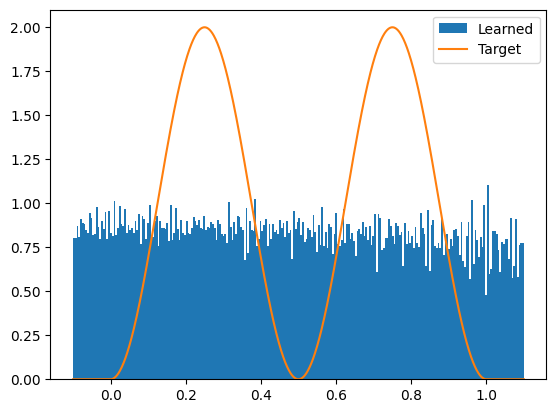

In [11]:

z = rng.randn(ArrayXf, (1, 1_000_000))
x = ArrayXf(net(nn.CoopVec(ArrayXf16(z))))
x = x[0] + x[1]

plt.hist(x, bins=256, range=(-0.1, 1.1), density=True, label="Learned")
plt.plot(x_ref, w_ref, label="Target")
plt.legend()

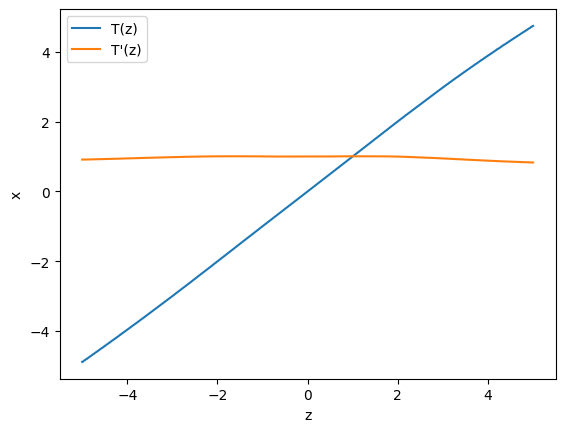

In [12]:

z = dr.linspace(Float32, -5, 5, 1_000)
z = ArrayXf(z)
x = ArrayXf(net(nn.CoopVec(ArrayXf16(z))))
dx = net.detJ()

z = z[0]
x = x[0]

plt.plot(z, x, label="T(z)")
plt.plot(z, dx, label="T'(z)")
plt.ylabel("x")
plt.xlabel("z")
plt.legend()

## Training

In [ ]:

opt = Adam(lr=0.00001, params={"weights": Float32(weights)})
scaler = GradScaler()

n = 200_000
batch_size = 2**14
iterator = tqdm.tqdm(range(n))
its = []
losses = []
for it in iterator:
    weights[:] = Float16(opt["weights"])

    z: ArrayXf = rng.randn(ArrayXf, (1, batch_size))

    x = ArrayXf(net(nn.CoopVec(ArrayXf16(z))))
    detJ = dr.maximum(Float32(net.detJ()), 0)
    p_ref = dr.maximum(ref.pdf(x), 0) + 1e-14
    reparam = p_ref * detJ

    # Defensive sampling
    r2 = ArrayXf(1 + dr.sum(z**2))
    x2 = z / dr.sqrt(r2)
    detJ2 = 1 / r2**2
    p_ref2 = dr.maximum(ref.pdf(x2), 0) + 1e-10
    reparam2 = p_ref2 * detJ2

    alpha = 1e-3
    reparam = reparam * (1 - alpha) + reparam2 * alpha

    loss = -dr.mean(dr.log(reparam), axis=None)

    dr.backward(scaler.scale(loss))
    scaler.step(opt)

    if (it + 1) % 10 == 0:
        loss = loss.numpy().item()
        losses.append(loss)
        its.append(it)
        iterator.set_postfix({"loss": loss})

 61%|████████████████████████████████████████████████████████████████████████████                                                | 122752/200000 [01:49<01:04, 1193.29it/s, loss=1.52]

In [ ]:

plt.plot(its, losses)
plt.ylabel("Loss")
plt.xlabel("Iteration")

## Visualize

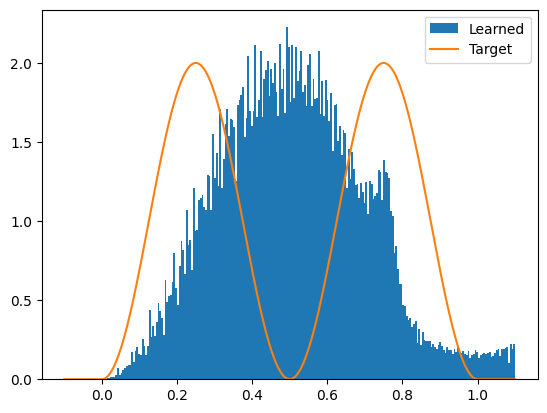

In [20]:

z = rng.randn(ArrayXf, (1, 1_000_000))
x = ArrayXf(net(nn.CoopVec(ArrayXf16(z))))
x = x[0] + x[1]

plt.hist(x, bins=256, range=(-0.1, 1.1), density=True, label="Learned")
plt.plot(x_ref, w_ref, label="Target")
plt.legend()

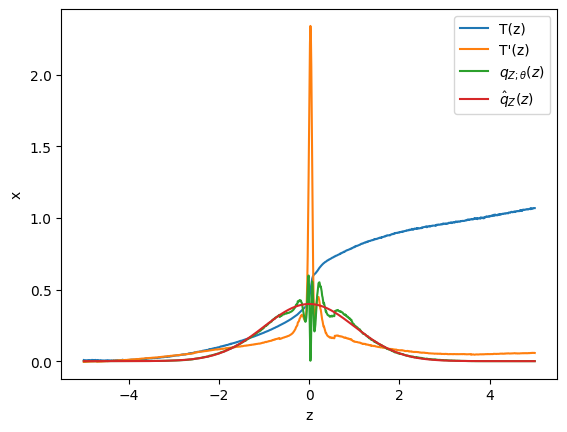

In [19]:

z = dr.linspace(Float32, -5, 5, 1_000)
z = ArrayXf(z)
x = ArrayXf(net(nn.CoopVec(ArrayXf16(z))))
dx = net.detJ()
q = ref.pdf(x) * dx
q_hat = std_normal_pdf(z)

z = z[0]
x = x[0]
q = q[0]
q_hat = q_hat[0]

plt.plot(z, x, label="T(z)")
plt.plot(z, dx, label="T'(z)")
plt.plot(z, q, label=r"$q_{Z;\theta}(z)$")
plt.plot(z, q_hat, label=r"$\hat q_Z(z)$")
plt.ylabel("x")
plt.xlabel("z")
plt.legend()